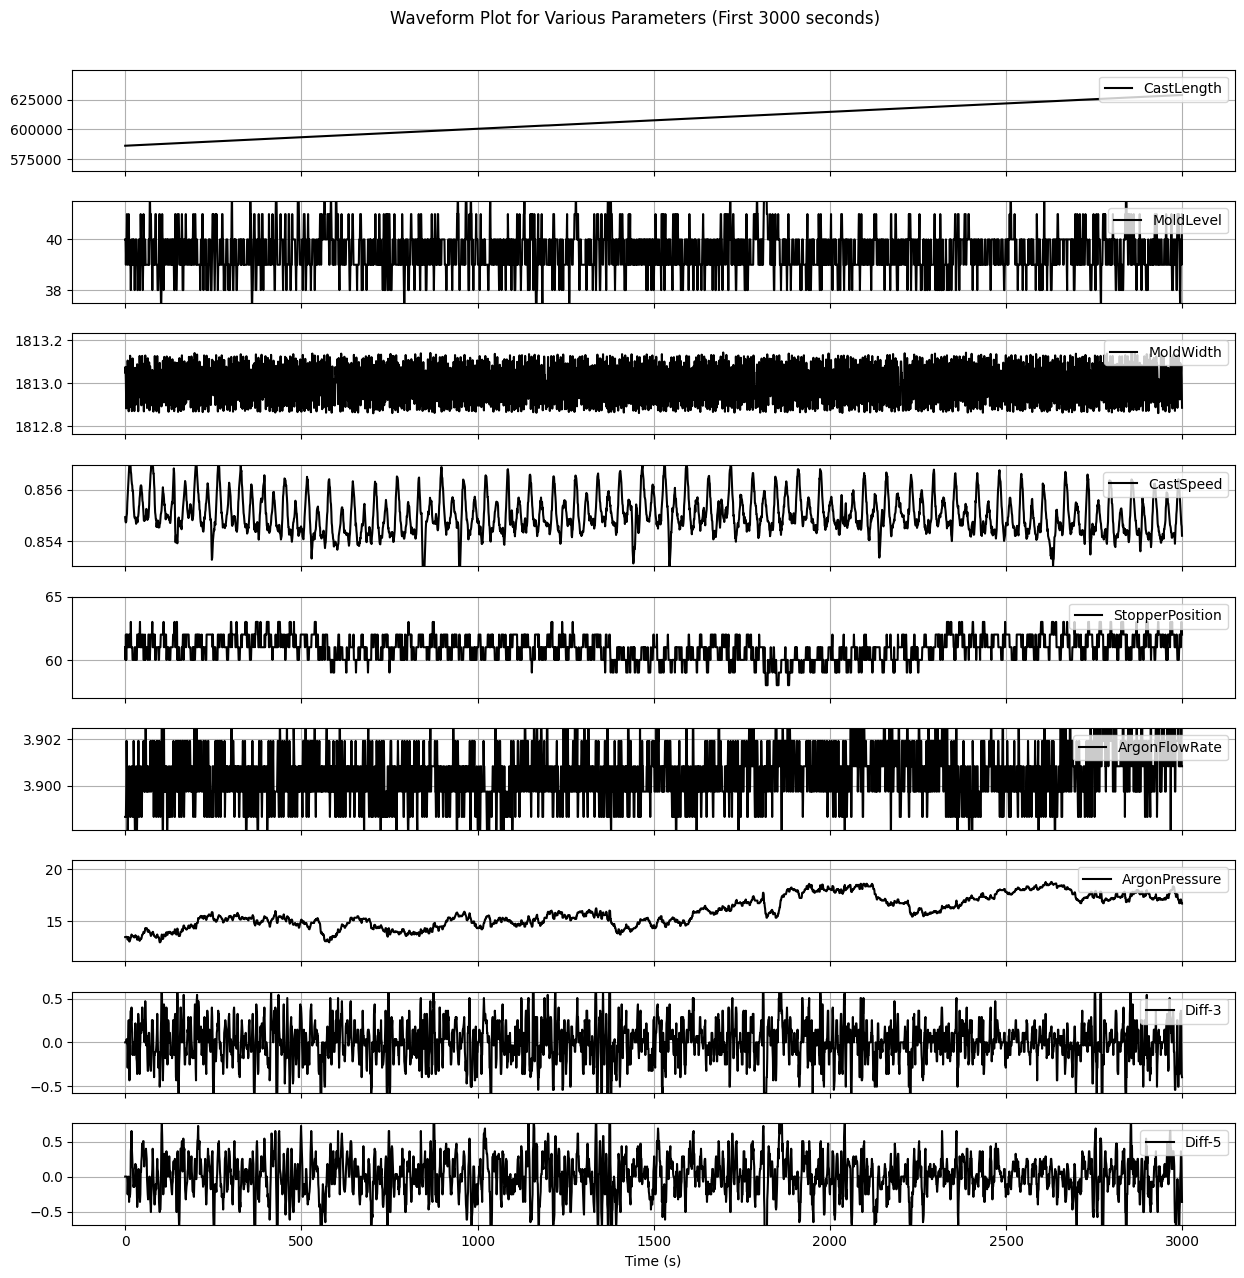

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the first 9000 seconds (9000 rows since each row represents one second)
df_selected = df.iloc[:3000]

# Extract the required columns
columns_to_plot = ['CastLength', 'MoldLevel', 'MoldWidth', 'CastSpeed', 
                   'StopperPosition', 'ArgonFlowRate', 'ArgonPressure', 'Diff-3', 'Diff-5']
df_selected = df_selected[columns_to_plot]

# Function to calculate 1.5 * IQR limits
def iqr_limits(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Plot each column in a more compact format with legend, black color, and adjusted y-axis limits using 1.5 * IQR
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(15, 15), sharex=True)
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(columns_to_plot):
    lower_bound, upper_bound = iqr_limits(df_selected[col])
    axs[i].plot(df_selected.index, df_selected[col], label=col, color='black')
    axs[i].set_ylabel('')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)
    # Adjust y-axis limits to highlight the shape of the wave without outliers
    axs[i].set_ylim(lower_bound, upper_bound)

axs[-1].set_xlabel('Time (s)')

plt.suptitle('Waveform Plot for Various Parameters (First 3000 seconds)', y=0.92)
plt.savefig('Sample display.png')
plt.show()



In [1]:
pip install pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/4289962063.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/4289962063.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/4289962063.py:23: IntegrationWarning: The algorithm does not converg

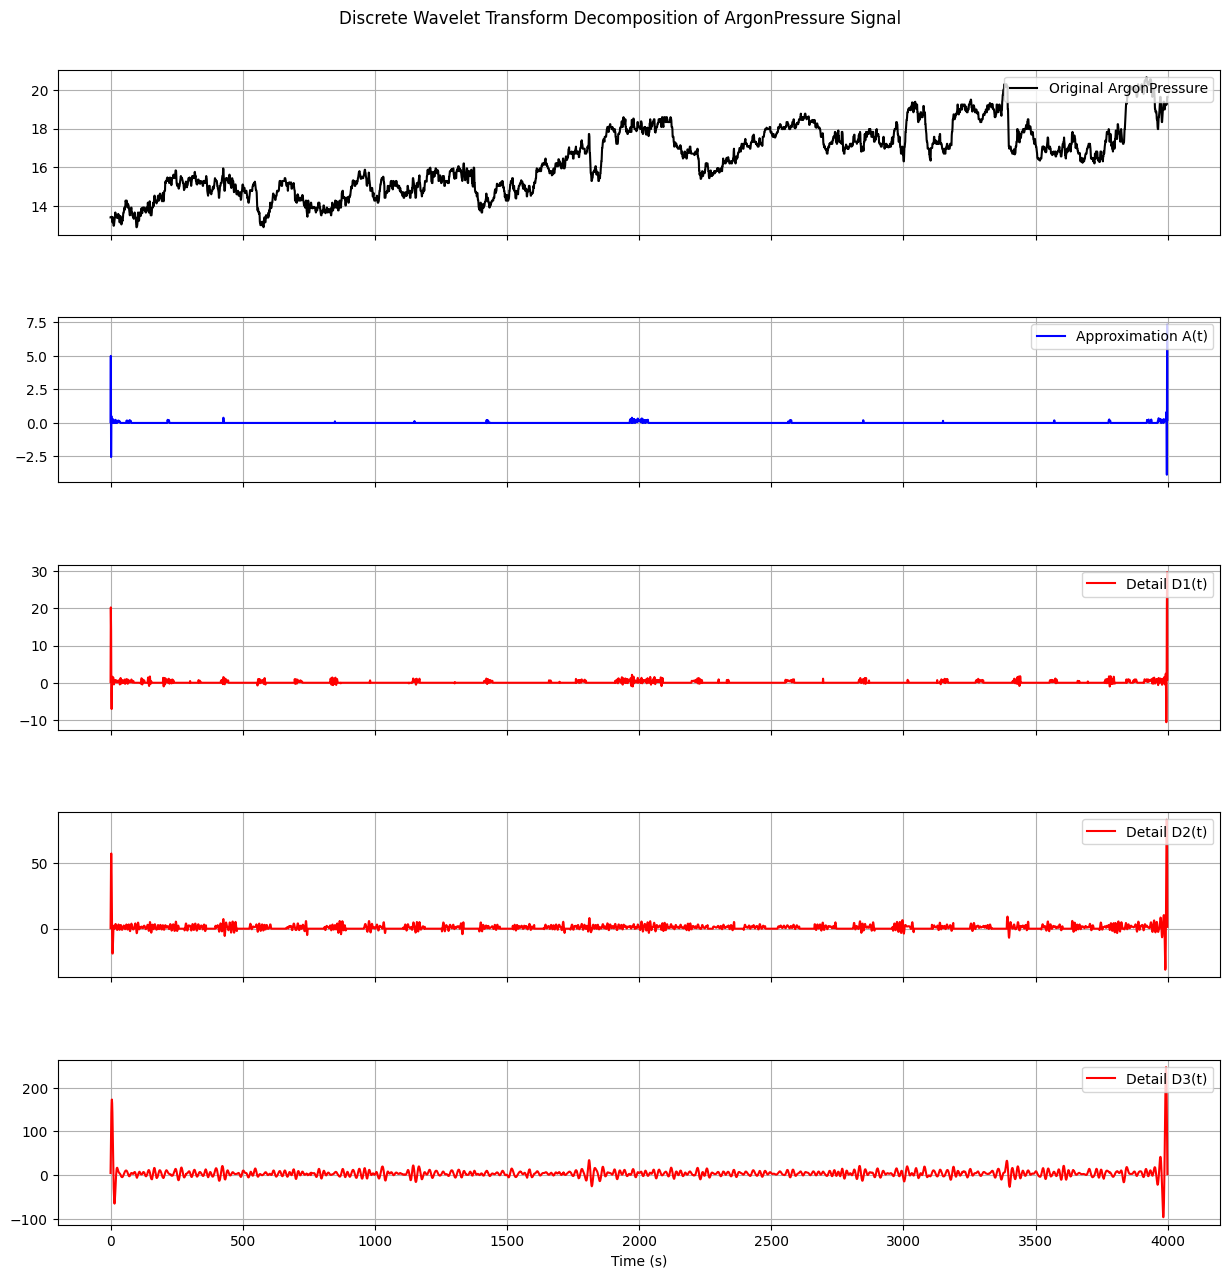

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the first 9000 seconds (9000 rows since each row represents one second)
df_selected = df.iloc[:4000]

# Extract the ArgonPressure signal from the selected data
argon_pressure = df_selected['ArgonPressure'].values
time = np.arange(len(argon_pressure))

# Define the wavelet basis function psi
def psi(t):
    return np.exp(-t**2) * np.cos(5*t)  # Example: Gaussian-modulated cosine (Morlet wavelet)

# Define the DWT function
def dwt(x, a, b):
    return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]

# Define the scale and translation parameters
a0 = 2
b0 = 1
scales = [a0**j for j in range(1, 5)]  # Example scales
translations = [b0 * k for k in range(len(argon_pressure))]

# Calculate the DWT coefficients
coeffs = np.zeros((len(scales), len(translations)))
for j, a in enumerate(scales):
    for k, b in enumerate(translations):
        coeffs[j, k] = dwt(argon_pressure, a, b)

# Reconstruct the signal using the approximation and detail coefficients
A = coeffs[0, :]
D = coeffs[1:, :]

# Plot the original signal and the decomposed waves
fig, axs = plt.subplots(len(D) + 2, 1, figsize=(15, 15), sharex=True)
fig.subplots_adjust(hspace=0.5)

# Plot original signal
axs[0].plot(time, argon_pressure, label='Original ArgonPressure', color='black')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot approximation signal
axs[1].plot(time, A, label='Approximation A(t)', color='blue')
axs[1].legend(loc='upper right')
axs[1].grid(True)
cc 
# Plot detail signals
for i, D_i in enumerate(D):
    axs[i+2].plot(time, D_i, label=f'Detail D{i+1}(t)', color='red')
    axs[i+2].legend(loc='upper right')
    axs[i+2].grid(True)

axs[-1].set_xlabel('Time (s)')

plt.suptitle('Discrete Wavelet Transform Decomposition of ArgonPressure Signal', y=0.92)
plt.savefig('DWT-Argon.png')
plt.show()


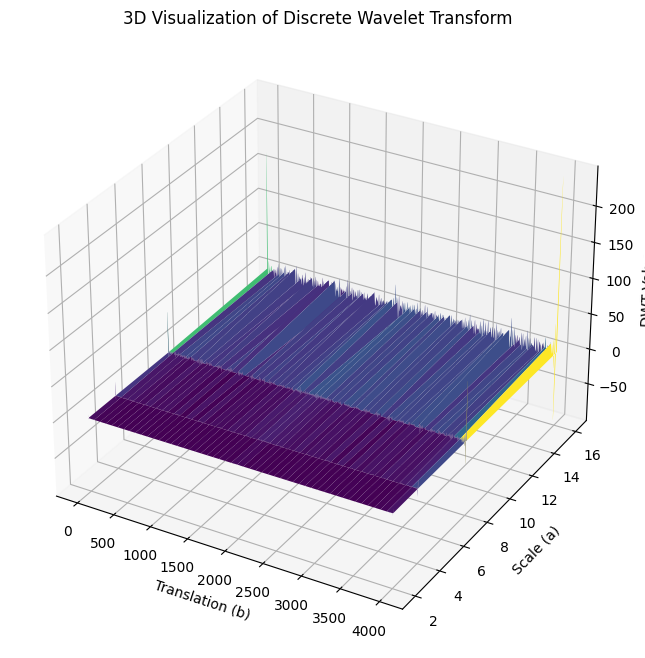

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare grid data for 3D plot
A, B = np.meshgrid(translations, scales)
Z = coeffs

# Plot the surface
ax.plot_surface(A, B, Z, cmap='viridis')

# Set labels
ax.set_xlabel('Translation (b)')
ax.set_ylabel('Scale (a)')
ax.set_zlabel('DWT Value')
ax.set_title('3D Visualization of Discrete Wavelet Transform')

plt.savefig('3D-DWT.png')
plt.show()

In [15]:
def calculate_wavelet_entropy(coeffs):
    energy = np.array([np.sum(c**2) for c in coeffs])
    total_energy = np.sum(energy)
    entropy = -np.sum((energy / total_energy) * np.log(energy / total_energy))
    return entropy

/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/2042389768.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/2042389768.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/2042389768.py:23: IntegrationWarning: The algorithm does not converg

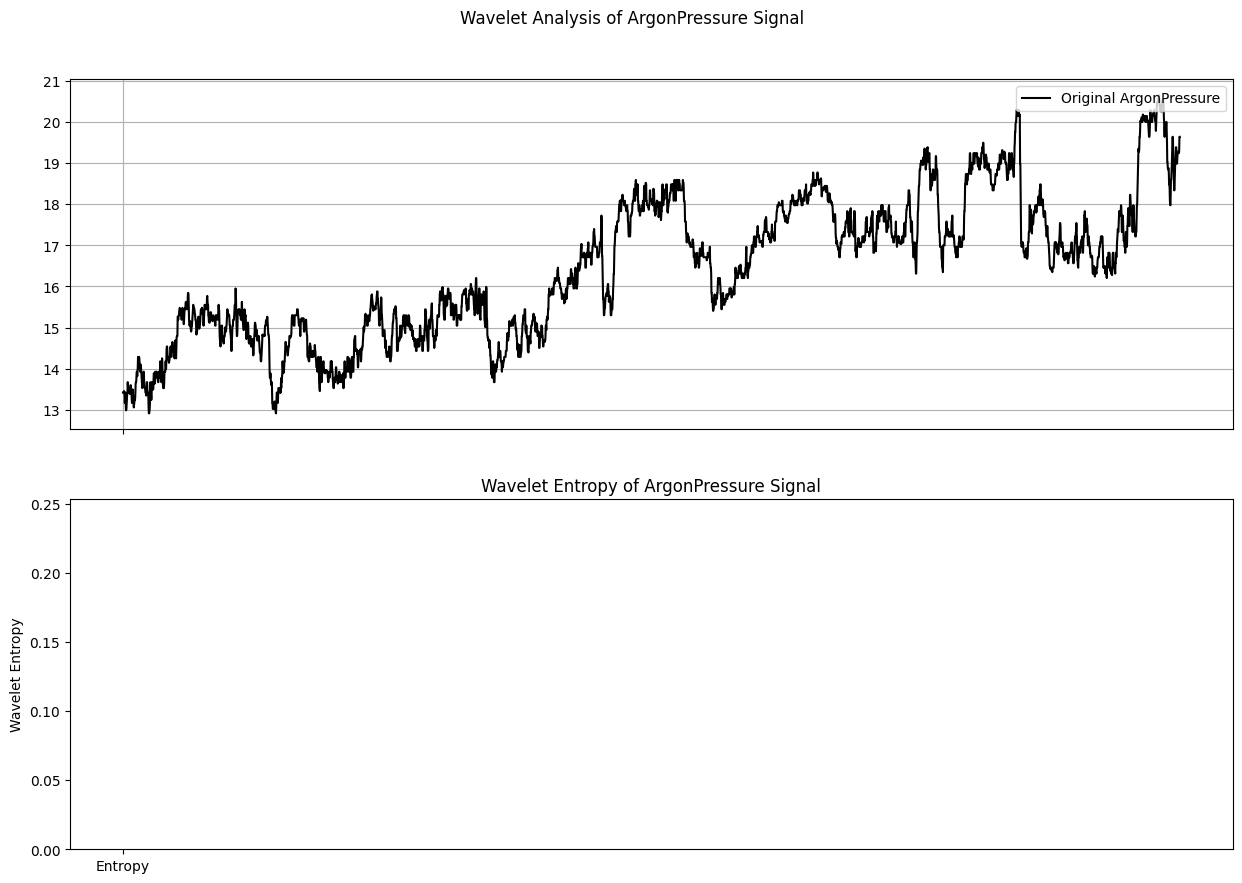

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the first 9000 seconds (9000 rows since each row represents one second)
df_selected = df.iloc[:4000]

# Extract the ArgonPressure signal from the selected data
argon_pressure = df_selected['ArgonPressure'].values
time = np.arange(len(argon_pressure))

# Define the wavelet basis function psi
def psi(t):
    return np.exp(-t**2) * np.cos(5*t)  # Example: Gaussian-modulated cosine (Morlet wavelet)

# Define the DWT function
def dwt(x, a, b):
    return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]

# Define the scale and translation parameters
a0 = 2
b0 = 1
scales = [a0**j for j in range(1, 5)]  # Example scales
translations = [b0 * k for k in range(len(argon_pressure))]

# Calculate the DWT coefficients
coeffs = np.zeros((len(scales), len(translations)))
for j, a in enumerate(scales):
    for k, b in enumerate(translations):
        coeffs[j, k] = dwt(argon_pressure, a, b)

# Reconstruct the signal using the approximation and detail coefficients
A = coeffs[0, :]
D = coeffs[1:, :]
entropy = calculate_wavelet_entropy(coeffs)

# Plot the original signal and the wavelet entropy
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot original signal
axs[0].plot(argon_pressure, label='Original ArgonPressure', color='black')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot wavelet entropy
axs[1].bar(['Entropy'], [entropy], color='blue')
axs[1].set_ylabel('Wavelet Entropy')
axs[1].set_title('Wavelet Entropy of ArgonPressure Signal')

plt.suptitle('Wavelet Analysis of ArgonPressure Signal', y=0.95)
plt.savefig('wavelet-entropy.png')
plt.show()

/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/3889382588.py:25: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand, 0, len(x)-1, limit=100)
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/3889382588.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(integrand, 0, len(x)-1, limit=100)
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/3889382588.py:25: IntegrationWarning:

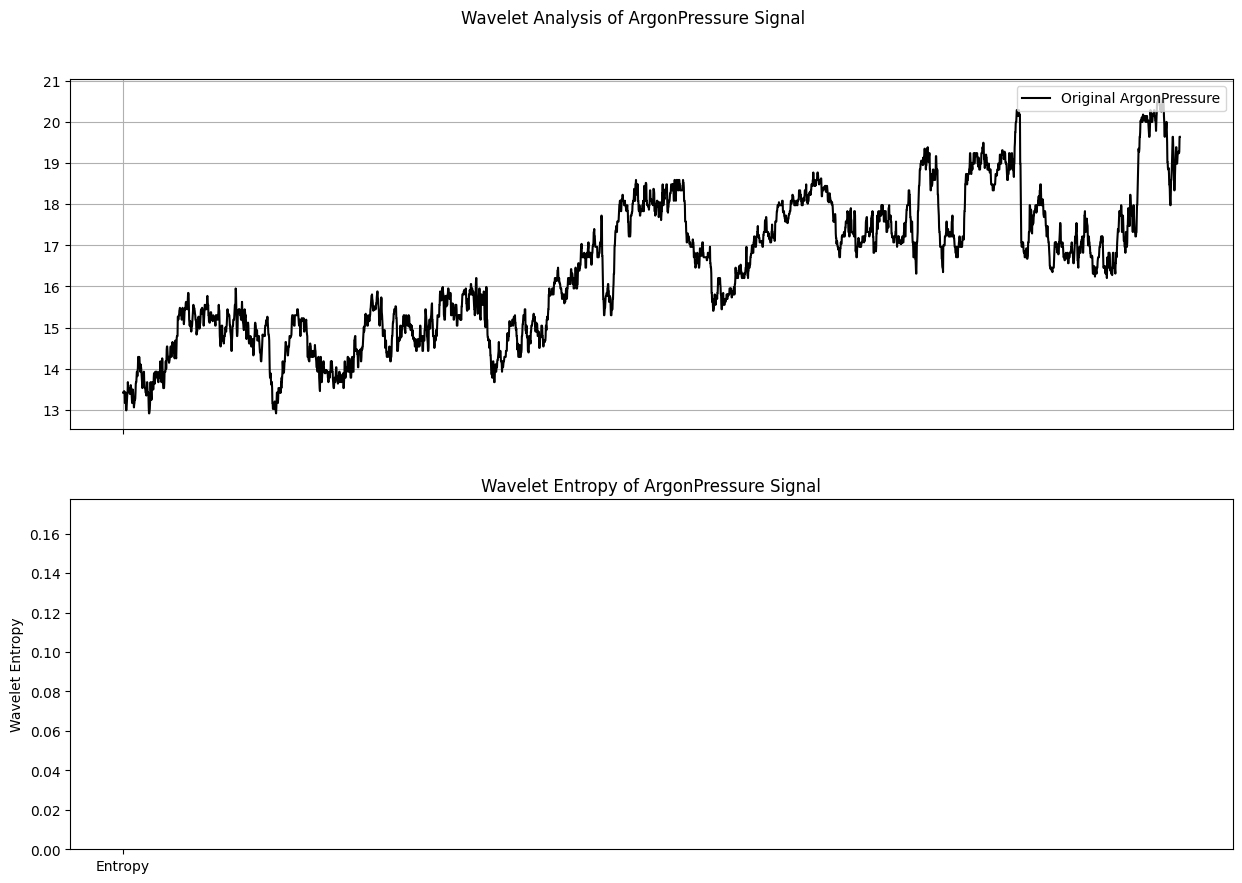

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the first 4000 seconds (4000 rows since each row represents one second)
df_selected = df.iloc[:4000]

# Extract the ArgonPressure signal from the selected data
argon_pressure = df_selected['ArgonPressure'].values
time = np.arange(len(argon_pressure))

# Define the wavelet basis function psi (Gaussian-modulated cosine, for example)
def psi(t):
    return np.exp(-t**2) * np.cos(5*t)

# Define the DWT function
def dwt(x, a, b):
    # Handle cases where t is not an integer
    integrand = lambda t: x[int(t)] * psi((t - b) / a)
    result, _ = quad(integrand, 0, len(x)-1, limit=100)
    return np.sqrt(a) * result

# Define the scale and translation parameters
a0 = 2
b0 = 1
scales = [a0**j for j in range(1, 5)]  # Example scales
translations = [b0 * k for k in range(len(argon_pressure))]

# Calculate the DWT coefficients
coeffs = np.zeros((len(scales), len(translations)))
for j, a in enumerate(scales):
    for k, b in enumerate(translations):
        coeffs[j, k] = dwt(argon_pressure, a, b)

# Calculate the wavelet entropy
def calculate_wavelet_entropy(coeffs):
    energy = np.sum(coeffs**2, axis=1)
    total_energy = np.sum(energy)
    entropy = -np.sum((energy / total_energy) * np.log(energy / total_energy))
    return entropy

entropy = calculate_wavelet_entropy(coeffs)

# Plot the original signal and the wavelet entropy
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot original signal
axs[0].plot(argon_pressure, label='Original ArgonPressure', color='black')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot wavelet entropy
axs[1].bar(['Entropy'], [entropy], color='blue')
axs[1].set_ylabel('Wavelet Entropy')
axs[1].set_title('Wavelet Entropy of ArgonPressure Signal')

plt.suptitle('Wavelet Analysis of ArgonPressure Signal', y=0.95)
plt.savefig('wavelet-entropy.png')
plt.show()

In [28]:
pip install pyst

  Obtaining dependency information for pyst from https://files.pythonhosted.org/packages/e2/be/73f3ebe281b9056f98c73609defa747b862a5908368fb49896044d38b434/pyst-0.9-py3-none-any.whl.metadata
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyst import st

file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the first 4000 seconds (4000 rows since each row represents one second)
df_selected = df.iloc[:4000]

# Extract the ArgonPressure signal from the selected data
argon_pressure = df_selected['ArgonPressure'].values

# Perform the Stockwell Transform (S-Transform)
S, t, f = st(argon_pressure)

# Calculate the magnitude of the transform coefficients
magnitude = np.abs(S)

# Plot the original signal and the S-transform
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot original signal
axs[0].plot(np.arange(len(argon_pressure)), argon_pressure, label='Original ArgonPressure', color='black')
axs[0].legend(loc='upper right')
axs[0].set_title('Original ArgonPressure Signal')
axs[0].grid(True)

# Plot the S-transform
cax = axs[1].imshow(magnitude, aspect='auto', extent=[0, len(argon_pressure), 0, len(f)], cmap='viridis', origin='lower')
fig.colorbar(cax, ax=axs[1])
axs[1].set_title('S-Transform (Magnitude)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Time')

plt.suptitle('S-Transform Analysis of ArgonPressure Signal', y=0.95)
plt.savefig('s-transform.png')
plt.show()

ModuleNotFoundError: No module named 'pyst'

Augmented Dickey-Fuller Test: Diff-3
ADF Test Statistic               -21.070758
p-value                            0.000000
# Lags Used                       46.000000
Number of Observations Used    21356.000000
Critical Value (1%)               -3.430656
Critical Value (5%)               -2.861675
Critical Value (10%)              -2.566842 

Augmented Dickey-Fuller Test: Diff-5
ADF Test Statistic               -20.853560
p-value                            0.000000
# Lags Used                       46.000000
Number of Observations Used    21356.000000
Critical Value (1%)               -3.430656
Critical Value (5%)               -2.861675
Critical Value (10%)              -2.566842 



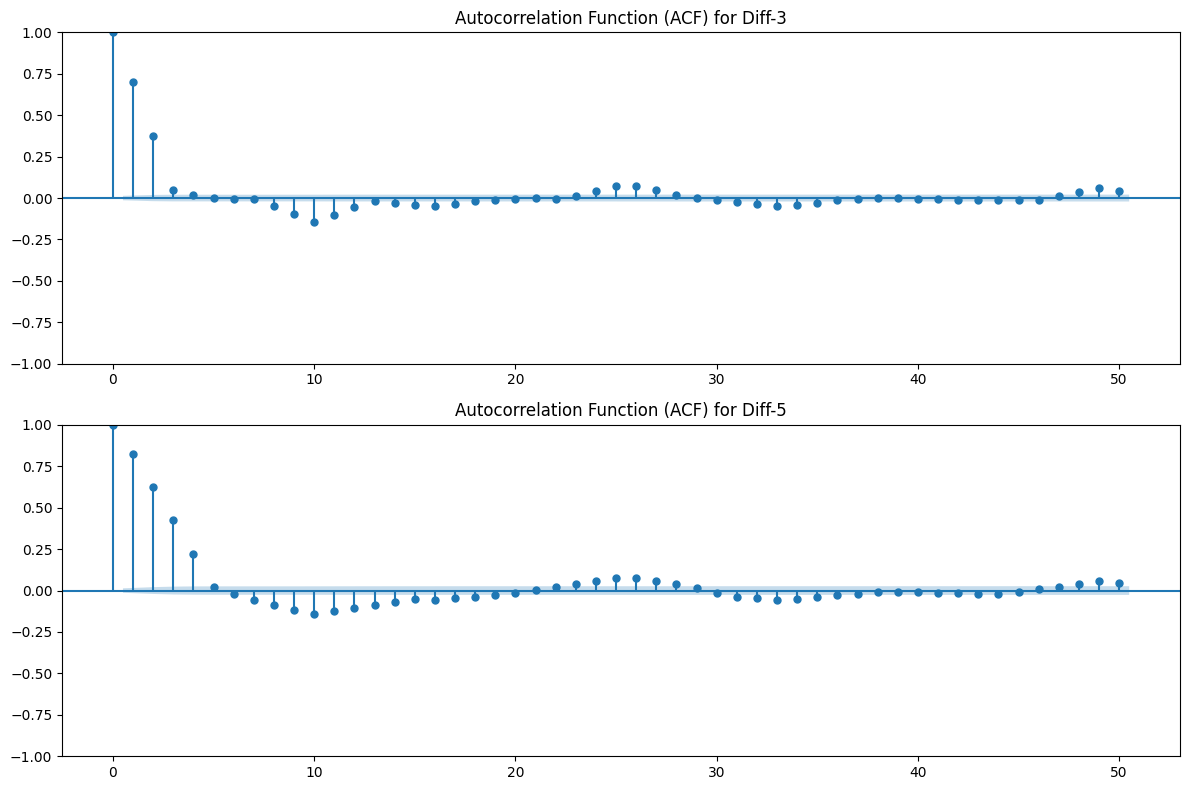

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Select the Diff-3 and Diff-5 columns
diff3 = df['Diff-3'].dropna()
diff5 = df['Diff-5'].dropna()

# Augmented Dickey-Fuller test function
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string(), '\n')
    return out

# Perform ADF test on Diff-3 and Diff-5
adf_test(diff3, title='Diff-3')
adf_test(diff5, title='Diff-5')

# Plot ACF for Diff-3
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(diff3, ax=ax[0], lags=50, alpha=0.05)
ax[0].set_title('Autocorrelation Function (ACF) for Diff-3')

# Plot ACF for Diff-5
plot_acf(diff5, ax=ax[1], lags=50, alpha=0.05)
ax[1].set_title('Autocorrelation Function (ACF) for Diff-5')

plt.tight_layout()
plt.savefig("ACF of Diff-3, Diff-5.png")
plt.show()


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Define the number of intervals and the interval size
num_intervals = 9
interval_size = 1000

# Extract the required columns
columns_to_plot = ['CastLength', 'MoldLevel', 'MoldWidth', 'CastSpeed', 
                   'StopperPosition', 'ArgonFlowRate', 'ArgonPressure', 'Diff-3', 'Diff-5']

# Function to calculate 1.5 * IQR limits
def iqr_limits(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Function to create waveform plots
def create_waveform_plots(df, interval_idx, interval_size, columns_to_plot):
    start_idx = interval_idx * interval_size
    end_idx = start_idx + interval_size
    df_interval = df.iloc[start_idx:end_idx]

    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(15, 15), sharex=True)
    fig.subplots_adjust(hspace=0.3)

    for i, col in enumerate(columns_to_plot):
        lower_bound, upper_bound = iqr_limits(df_interval[col])
        axs[i].plot(df_interval.index, df_interval[col], label=col, color='black')
        axs[i].set_ylabel('')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
        axs[i].set_ylim(lower_bound, upper_bound)

    axs[-1].set_xlabel('Time (s)')
    plt.suptitle(f'Waveform Plot for Various Parameters (Interval {start_idx+1}-{end_idx})', y=0.92)
    plt.savefig(f'Waveform_{start_idx+1}-{end_idx}.png')
    plt.close()

# Function to perform DWT and plot the results
def perform_dwt_and_plot(df, interval_idx, interval_size):
    start_idx = interval_idx * interval_size
    end_idx = start_idx + interval_size
    df_interval = df.iloc[start_idx:end_idx]
    argon_pressure = df_interval['ArgonPressure'].values
    time = np.arange(len(argon_pressure))

    # Define the wavelet basis function psi
    def psi(t):
        return np.exp(-t**2) * np.cos(5*t)  # Example: Gaussian-modulated cosine (Morlet wavelet)

    # Define the DWT function
    def dwt(x, a, b):
        return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]

    # Define the scale and translation parameters
    a0 = 2
    b0 = 1
    scales = [a0**j for j in range(1, 5)]  # Example scales
    translations = [b0 * k for k in range(len(argon_pressure))]

    # Calculate the DWT coefficients
    coeffs = np.zeros((len(scales), len(translations)))
    for j, a in enumerate(scales):
        for k, b in enumerate(translations):
            coeffs[j, k] = dwt(argon_pressure, a, b)

    # Reconstruct the signal using the approximation and detail coefficients
    A = coeffs[0, :]
    D = coeffs[1:, :]

    # Plot the original signal and the decomposed waves
    fig, axs = plt.subplots(len(D) + 2, 1, figsize=(15, 15), sharex=True)
    fig.subplots_adjust(hspace=0.5)

    # Plot original signal
    axs[0].plot(time, argon_pressure, label='Original ArgonPressure', color='black')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    # Plot approximation signal
    axs[1].plot(time, A, label='Approximation A(t)', color='blue')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    # Plot detail signals
    for i, D_i in enumerate(D):
        axs[i+2].plot(time, D_i, label=f'Detail D{i+1}(t)', color='red')
        axs[i+2].legend(loc='upper right')
        axs[i+2].grid(True)

    axs[-1].set_xlabel('Time (s)')
    plt.suptitle(f'Discrete Wavelet Transform Decomposition of ArgonPressure Signal (Interval {start_idx+1}-{end_idx})', y=0.92)
    plt.savefig(f'DWT_Argon_{start_idx+1}-{end_idx}.png')
    plt.close()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Prepare grid data for 3D plot
    A, B = np.meshgrid(translations, scales)
    Z = coeffs

    # Plot the surface
    ax.plot_surface(A, B, Z, cmap='viridis')

    # Set labels
    ax.set_xlabel('Translation (b)')
    ax.set_ylabel('Scale (a)')
    ax.set_zlabel('DWT Value')
    ax.set_title(f'3D Visualization of Discrete Wavelet Transform (Interval {start_idx+1}-{end_idx})')

    plt.savefig(f'3D_DWT_{start_idx+1}-{end_idx}.png')
    plt.close()

# Process each interval
for interval_idx in range(num_intervals):
    create_waveform_plots(df, interval_idx, interval_size, columns_to_plot)
    perform_dwt_and_plot(df, interval_idx, interval_size)

"Processing complete."


/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/1870666695.py:64: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/1870666695.py:64: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/1870666695.py:64: IntegrationWarning: The occurrence of roundoff err

'Processing complete.'

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Waveform_0-1000.png'

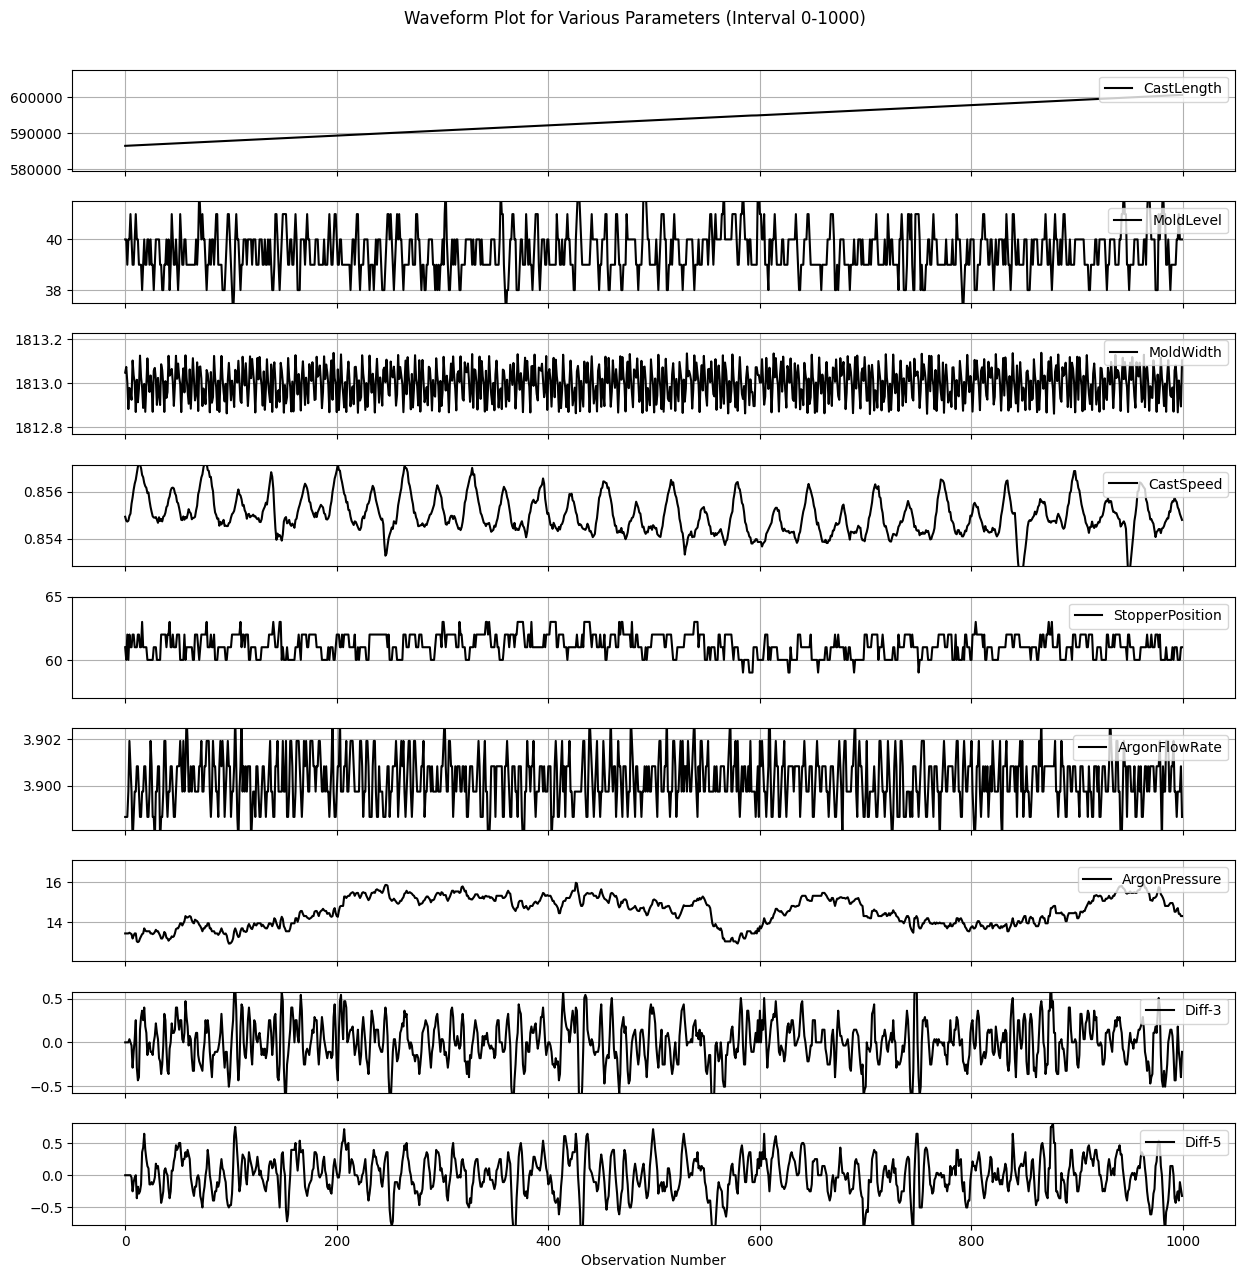

In [35]:
import matplotlib.pyplot as plt

# Define the interval size
interval_size = 1000

# Extract the required columns
columns_to_plot = ['CastLength', 'MoldLevel', 'MoldWidth', 'CastSpeed', 
                   'StopperPosition', 'ArgonFlowRate', 'ArgonPressure', 'Diff-3', 'Diff-5']

# Function to calculate 1.5 * IQR limits
def iqr_limits(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Create waveform plots for the first interval
start_idx = 0
end_idx = interval_size
df_interval = df.iloc[start_idx:end_idx]

fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(15, 15), sharex=True)
fig.subplots_adjust(hspace=0.3)

for i, col in enumerate(columns_to_plot):
    lower_bound, upper_bound = iqr_limits(df_interval[col])
    axs[i].plot(range(start_idx, end_idx), df_interval[col], label=col, color='black')
    axs[i].set_ylabel('')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)
    axs[i].set_ylim(lower_bound, upper_bound)

axs[-1].set_xlabel('Observation Number')
plt.suptitle(f'Waveform Plot for Various Parameters (Interval {start_idx}-{end_idx})', y=0.92)
plt.savefig(f'/mnt/data/Waveform_{start_idx}-{end_idx}.png')
plt.show()


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D

# Load the provided Excel file
file_path = '21837-3ZT.xlsx'
df = pd.read_excel(file_path)

# Define the number of intervals and the interval size
num_intervals = 9
interval_size = 1000

# Extract the required columns
columns_to_plot = ['CastLength', 'MoldLevel', 'MoldWidth', 'CastSpeed', 
                   'StopperPosition', 'ArgonFlowRate', 'ArgonPressure', 'Diff-3', 'Diff-5']

# Function to calculate 1.5 * IQR limits
def iqr_limits(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Function to create waveform plots
def create_waveform_plots(df, interval_idx, interval_size, columns_to_plot):
    start_idx = interval_idx * interval_size
    end_idx = start_idx + interval_size
    df_interval = df.iloc[start_idx:end_idx]

    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(15, 15), sharex=True)
    fig.subplots_adjust(hspace=0.3)

    for i, col in enumerate(columns_to_plot):
        lower_bound, upper_bound = iqr_limits(df_interval[col])
        axs[i].plot(range(start_idx, end_idx), df_interval[col], label=col, color='black')
        axs[i].set_ylabel('')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
        axs[i].set_ylim(lower_bound, upper_bound)

    axs[-1].set_xlabel('Observation Number')
    plt.suptitle(f'Waveform Plot for Various Parameters (Interval {start_idx}-{end_idx})', y=0.92)
    plt.savefig(f'Waveform_{start_idx}-{end_idx}.png')
    plt.close()

# Function to perform DWT and plot the results
def perform_dwt_and_plot(df, interval_idx, interval_size):
    start_idx = interval_idx * interval_size
    end_idx = start_idx + interval_size
    df_interval = df.iloc[start_idx:end_idx]
    argon_pressure = df_interval['ArgonPressure'].values
    time = np.arange(start_idx, end_idx)

    # Define the wavelet basis function psi
    def psi(t):
        return np.exp(-t**2) * np.cos(5*t)  # Example: Gaussian-modulated cosine (Morlet wavelet)

    # Define the DWT function
    def dwt(x, a, b):
        return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]

    # Define the scale and translation parameters
    a0 = 2
    b0 = 1
    scales = [a0**j for j in range(1, 5)]  # Example scales
    translations = [b0 * k for k in range(len(argon_pressure))]

    # Calculate the DWT coefficients
    coeffs = np.zeros((len(scales), len(translations)))
    for j, a in enumerate(scales):
        for k, b in enumerate(translations):
            coeffs[j, k] = dwt(argon_pressure, a, b)

    # Reconstruct the signal using the approximation and detail coefficients
    A = coeffs[0, :]
    D = coeffs[1:, :]

    # Plot the original signal and the decomposed waves
    fig, axs = plt.subplots(len(D) + 2, 1, figsize=(15, 15), sharex=True)
    fig.subplots_adjust(hspace=0.5)

    # Plot original signal
    axs[0].plot(time, argon_pressure, label='Original ArgonPressure', color='black')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    # Plot approximation signal
    axs[1].plot(time, A, label='Approximation A(t)', color='blue')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)

    # Plot detail signals
    for i, D_i in enumerate(D):
        axs[i+2].plot(time, D_i, label=f'Detail D{i+1}(t)', color='red')
        axs[i+2].legend(loc='upper right')
        axs[i+2].grid(True)

    axs[-1].set_xlabel('Observation Number')
    plt.suptitle(f'Discrete Wavelet Transform Decomposition of ArgonPressure Signal (Interval {start_idx}-{end_idx})', y=0.92)
    plt.savefig(f'DWT_Argon_{start_idx}-{end_idx}.png')
    plt.close()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Prepare grid data for 3D plot
    A, B = np.meshgrid(translations, scales)
    Z = coeffs

    # Plot the surface
    ax.plot_surface(A, B, Z, cmap='viridis')

    # Set labels
    ax.set_xlabel('Translation (b)')
    ax.set_ylabel('Scale (a)')
    ax.set_zlabel('DWT Value')
    ax.set_title(f'3D Visualization of Discrete Wavelet Transform (Interval {start_idx}-{end_idx})')

    plt.savefig(f'3D_DWT_{start_idx}-{end_idx}.png')
    plt.close()

# Process each interval
for interval_idx in range(num_intervals):
    create_waveform_plots(df, interval_idx, interval_size, columns_to_plot)
    perform_dwt_and_plot(df, interval_idx, interval_size)

"Processing complete."


/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/50084527.py:64: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/50084527.py:64: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return np.sqrt(a) * quad(lambda t: x[int(t)] * psi((t - b) / a), 0, len(x)-1)[0]
/var/folders/ym/gjm_msq15slcvwxnmzx6pskw0000gn/T/ipykernel_15731/50084527.py:64: IntegrationWarning: The occurrence of roundoff error is 

'Processing complete.'